# Advanced Physical Modelling on Disk

In the previous tutorial, we simply modelled the chemistry of a static cloud for 1 Myr. This is unlikely to meet everybody's modelling needs and UCLCHEM is capable of modelling much more complex environments such as prestellar cores and shocks. In this tutorial, we model both a prestellar core and a shock to explore how these models work and to demonstrate the workflow that the UCLCHEM team normally follow. In tutorial 2a, we approach the modeling in a more classic approach, by writing the outputs to files, before passing them to the subsequent model class. In tutorial 2b, we calculate the exact same models, but take advantage of the model objects in order to perform all calculations in memory, bypassing the file system entirely.

In [1]:
import uclchem
import matplotlib.pyplot as plt
import os

## The Prestellar Core

### Initial Conditions (Phase 1)
UCLCHEM typically starts with the gas in atomic/ionic form with no molecules. However, this clearly is not appropriate when modelling an object such as a prestellar core. In these objects, the gas is already evolved and there should be molecules in the gas phase as well as ice mantles on the dust. To allow for this, one must provide some initial abundances to the model. There are many ways to do this, but we typically chose to run a preliminary model to produce our abundances. In many UCLCHEM papers, we refer to the preliminary model as *phase 1* and the science model as *phase 2*. Phase 1 simply models a collapsing cloud and phase 2 models the object in question.

To do this, we will use `uclchem.model.Cloud()` to run a model where a cloud of gas collapses from a density of $10^2 cm^{-3}$ to our prestellar core density of $10^6 cm^{-3}$, keeping all other parameters constant. During this collapse, chemistry will occur, and we can assume the final abundances of this model will be reasonable starting abundances for the prestellar core.

In [2]:
# set a parameter dictionary for cloud collapse model
param_dict = {
    "endAtFinalDensity": False,  # stop at finalTime
    "freefall": True,  # increase density in freefall
    "initialDens": 1e2,  # starting density
    "finalDens": 1e6,  # final density
    "initialTemp": 10.0,  # temperature of gas
    "finalTime": 6.0e6,  # final time
    "rout": 0.1,  # radius of cloud in pc
    "baseAv": 1.0,  # visual extinction at cloud edge.
    "abundSaveFile": "../examples/test-output/startcollapse.dat",  # save final abundances to file
    "outputFile": "../examples/test-output/phase1-full.dat",
}
if not os.path.exists("../examples/test-output/"):
    os.makedirs("../examples/test-output/")

cloud = uclchem.model.Cloud(param_dict=param_dict)
# Alternatively we could load in a pre-existing version like so
# cloud = uclchem.model.Cloud(read_file="../examples/test-output/phase1-full.dat")
# For file reading demonstration purposes, we will now delete the object.
del cloud

With that done, we have run the model and stored the outputs into the object `cloud`, while also storing the final abundances by using: `param_dict["abundSaveFile"]`. We can pass this value our prestellar core model to use those abundances as our initial abundances. Of note, the parameter `abundSaveFile` has been removed from param_dict by creating the `cloud` object.

### Running the Science Model (Phase 2)

We need to change just a few things in `param_dict` to set up the prestellar core model. The key one is that UCLCHEM saves final abundances to `abundSaveFile` but loads them from `abundLoadFile` so we need to provide the `abundLoadFile` parameter to make the abundances we just produced our initial abundances.

We also want to turn off freefall and change how long the model runs for.


In [3]:
# change other bits of input to set up phase 2
param_dict["initialDens"] = 1e6
param_dict["finalTime"] = 1e6
param_dict["freefall"] = False

# freeze out is completely overwhelmed by thermal desorption
# so turning it off has no effect on abundances but speeds up integrator.
param_dict["freezeFactor"] = 0.0

param_dict["abstol_factor"] = 1e-18
param_dict["reltol"] = 1e-12

# pop is dangerous, it removes the original key so you can't rerun this cell.
param_dict["abundLoadFile"] = "../examples/test-output/startcollapse.dat"
param_dict["outputFile"] = "../examples/test-output/phase2-full.dat"

p_core = uclchem.model.PrestellarCore(temp_indx=3, max_temperature=300.0, param_dict=param_dict)
# For file reading demonstration purposes, we will now delete the object.
del p_core

 At T(=R1) and step size H(=R2), the                                             
 corrector convergence failed repeatedly                                         
 or with ABS(H) = HMIN.                                                          
In the above message, R1 =   0.7285623925770D+13   R2 =   0.6183848452514D+03
 ISTATE -5 - shortening step at time   230557.71916994615      years


Note that we've made two changes to the parameters here which aren't strictly necessary but can be helpful in certain situations.

Since the gas temperature increases throughout a prestellar core model, freeze out is much slower than thermal desorption for all but the first few time steps. Turning it off doesn't affect the abundances but will speed up the solution.

We also change abstol and reltol here, largely to demonstrate their use. They control the integrator accuracy and whilst making them smaller does slow down successful runs, it can make runs complete that stall completely otherwise or give correct solutions where lower tolerances allow issues like element conservation failure to sneak in. If your code does not complete or element conservation fails, you can change them.

### Checking the Result
With a successful run, we can check the output. We first load the file and check the abundance conservation, then we can plot it up. To demonstrate how these files can be read in the new class method, we recreate the `p_core` object but instead of passing `param_dict`, we use the argument `read_file` and point it to the full output file we previously wrote to.

In [4]:
p_core = uclchem.model.PrestellarCore(read_file="../examples/test-output/phase2-full.dat")
p_core.check_conservation()

Element conservation report
{'H': '0.002%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}


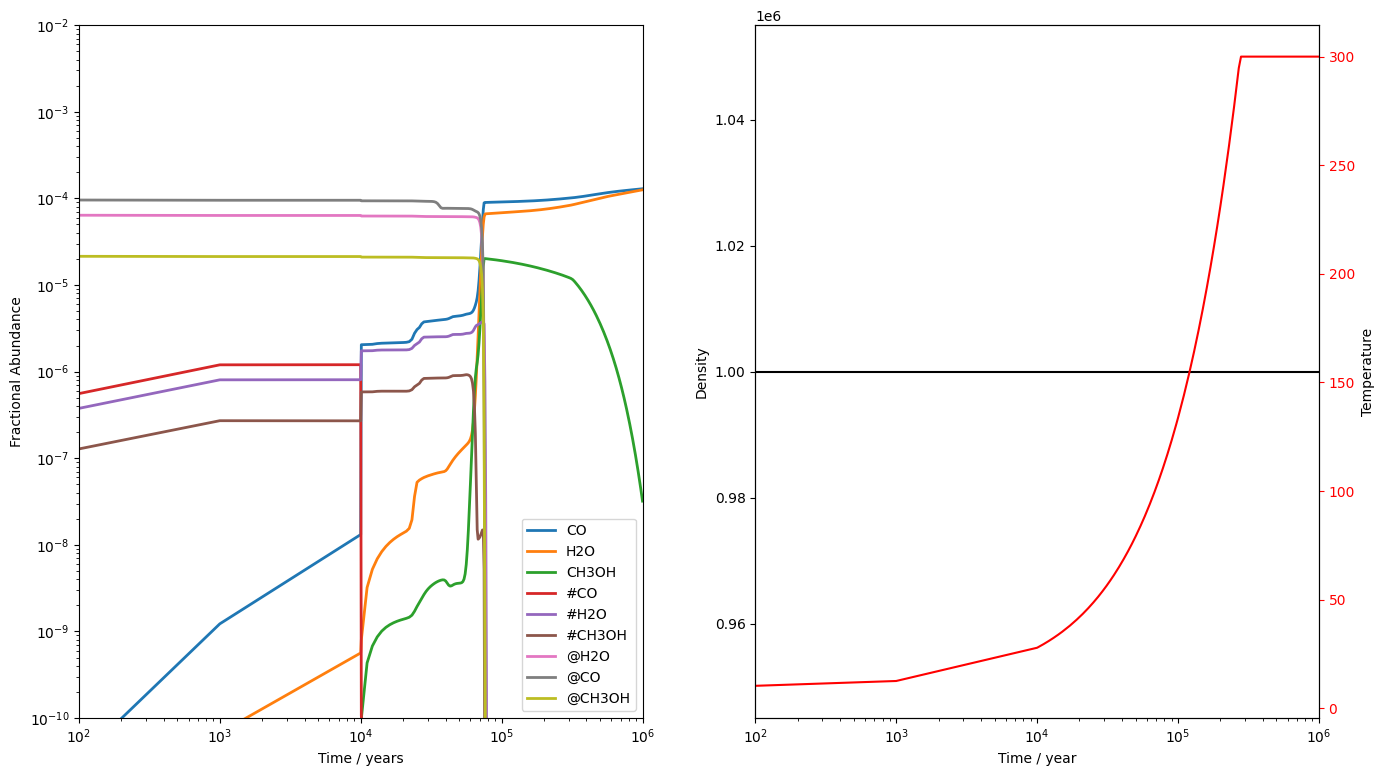

In [5]:
df_p_core = p_core.get_dataframes()
species = ["CO", "H2O", "CH3OH", "#CO", "#H2O", "#CH3OH", "@H2O", "@CO", "@CH3OH"]
fig, [ax, ax2] = plt.subplots(1, 2, figsize=(16, 9))
ax = p_core.plot_species(ax, species)
settings = ax.set(
    yscale="log",
    xlim=(1e2, 1e6),
    ylim=(1e-10, 1e-2),
    xlabel="Time / years",
    ylabel="Fractional Abundance",
    xscale="log",
)

ax2.plot(df_p_core["Time"], df_p_core["Density"], color="black")
ax2.set(xscale="log")
ax3 = ax2.twinx()
ax3.plot(df_p_core["Time"], df_p_core["gasTemp"], color="red")
ax2.set(xlabel="Time / year", ylabel="Density")
ax3.set(ylabel="Temperature", facecolor="red", xlim=(1e2, 1e6))
ax3.tick_params(axis="y", colors="red")

Here, we see the value of running a collapse phase before the science run. Having run a collapse, we start this model with well developed ices and having material in the surface and bulk allows us to properly model the effect of warm up in a prestellar core. For example, the @CO abundance is $\sim10^{-4}$ and #CO is $\sim10^{-6}$. As the gas warms to around 30K, the #CO abundance drops drastically as CO's binding energy is such that it is efficiently desorbed from the surface at this temperature. However, the rest of the CO is trapped in the bulk, surrounded by more strongly bound H2O molecules. Thus, the @CO abundance stays high until the gas reaches around 130K, when the H2O molecules are released along with the entire bulk.

## Shocks

Essentially the same process should be followed for shocks. Let's run a C-type and J-type shock through a gas of density $10^4 cm^{-3}$. Again, we first run a simple cloud model to obtain some reasonable starting abundances, then we can run the shocks.

In [6]:
# set a parameter dictionary for phase 1 collapse model

param_dict = {
    "endAtFinalDensity": False,  # stop at finalTime
    "freefall": True,  # increase density in freefall
    "initialDens": 1e2,  # starting density
    "finalDens": 1e4,  # final density
    "initialTemp": 10.0,  # temperature of gas
    "finalTime": 6.0e6,  # final time
    "rout": 0.1,  # radius of cloud in pc
    "baseAv": 1.0,  # visual extinction at cloud edge.
    "abundSaveFile": "../examples/test-output/shockstart.dat",
}

shock_start = uclchem.model.Cloud(param_dict=param_dict)
# Alternatively we could load in a pre-existing version like so
# shock_start = uclchem.model.Cloud(read_file="../examples/test-output/shockstart.dat")
# For file reading demonstration purposes, we will now delete the object.
del shock_start

### C-shock

We'll first run a c-shock. We choose to crate a 40 km s $^{-1}$ shock through a gas of density $10^4$ cm $^{-3}$, using the abundances we just produced. Note that c-shock is the only model which returns an additional output in its result list. Shock models include an additional variable that can be accessed, the dissipation time. This can be retrieved like so `cshock.dissipation_time` where `cshock` would be the object created using `uclchem.model.CShock()`.

In [7]:
# change other bits of input to set up phase 2
param_dict["initialDens"] = 1e4
param_dict["finalTime"] = 1e6
param_dict["abundLoadFile"] = "../examples/test-output/shockstart.dat"
param_dict["outputFile"] = "../examples/test-output/cshock.dat"

cshock = uclchem.model.CShock(shock_vel=40, param_dict=param_dict)
dissipation_time = cshock.dissipation_time
# For file reading demonstration purposes, we will now delete the object.
del cshock

 Cannot have freefall on during cshock
 setting freefall=0 and continuing


The code completes fine. We do get a couple of warnings though. First, we're informed that `freefall` must be set to False for the C-shock model. Then we get a few integrator warnings. These are not important and can be ignored as long as the element conservation looks ok. However, it is an indication that the integrator did struggle with these ODEs under these conditions. As we load in this model, we could estimate the dissipation time using `uclchem.utils.cshock_dissipation_time()`, however, for this example we stored it from the object directly.

In [8]:
cshock = uclchem.model.CShock(read_file="../examples/test-output/cshock.dat")
# dissipation_time = uclchem.utils.cshock_dissipation_time(shock_vel=40, initial_dens=param_dict["initialDens"]) # As an example
cshock.check_conservation()

Element conservation report
{'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}


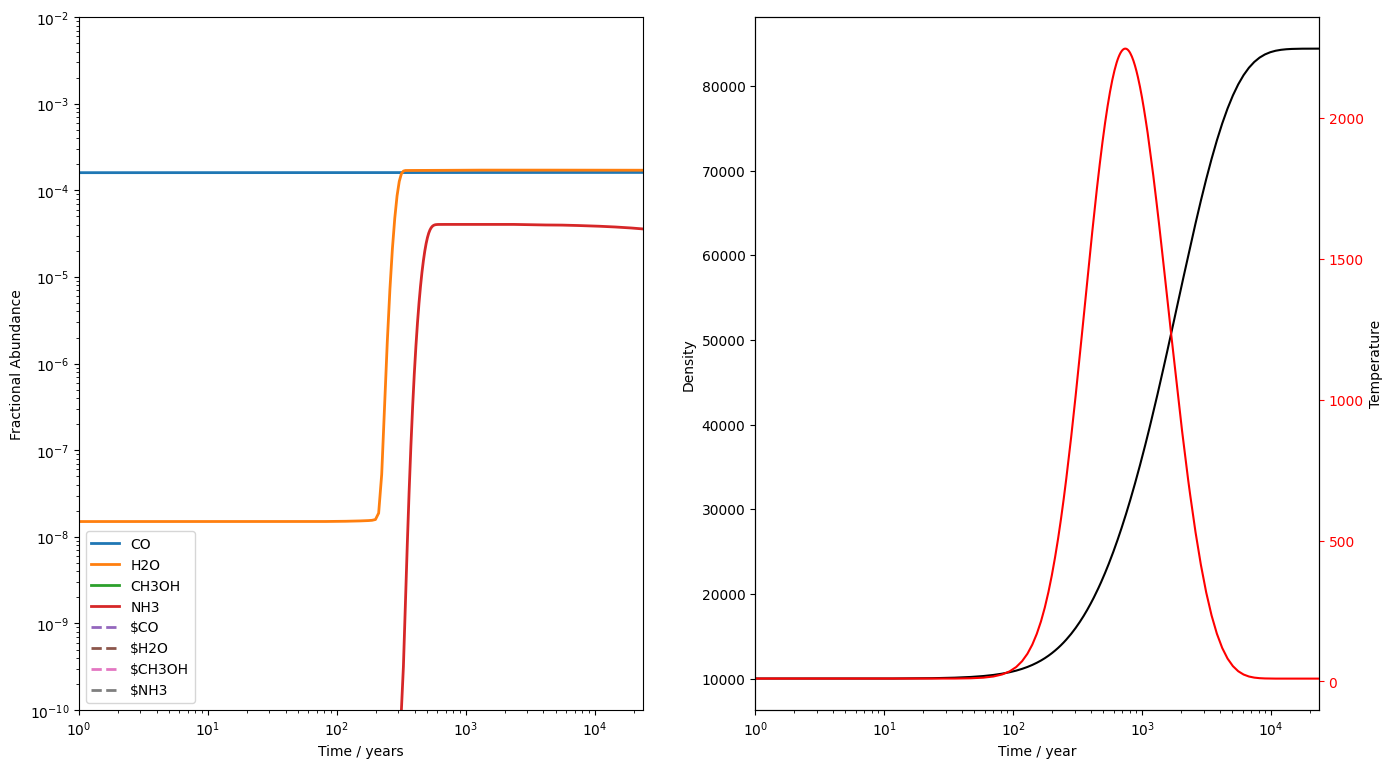

In [9]:
df_cshock = cshock.get_dataframes()
species = ["CO", "H2O", "CH3OH", "NH3", "$CO", "$H2O", "$CH3OH", "$NH3"]

fig, [ax, ax2] = plt.subplots(1, 2, figsize=(16, 9))
ax = cshock.plot_species(ax, species)
settings = ax.set(
    yscale="log",
    xlim=(1, 20 * dissipation_time),
    ylim=(1e-10, 1e-2),
    xlabel="Time / years",
    ylabel="Fractional Abundance",
    xscale="log",
)

ax2.plot(df_cshock["Time"], df_cshock["Density"], color="black")
ax2.set(xscale="log")
ax3 = ax2.twinx()
ax3.plot(df_cshock["Time"], df_cshock["gasTemp"], color="red")
ax2.set(xlabel="Time / year", ylabel="Density")
ax3.set(ylabel="Temperature", facecolor="red", xlim=(1, 20 * dissipation_time))
ax3.tick_params(axis="y", colors="red")
ax3.tick_params(axis="y", colors="red")

### J-shock
Running a j-shock is a simple case of changing function. We'll run a 10 km s $^{-1}$ shock through a gas of density $10^3$ cm $^{-3}$ gas this time. Note that nothing stops us using the initial abundances we produced for the c-shock. UCLCHEM will not check that the initial density matches the density of the `abundLoadFile`. It may not always be a good idea to do this, but we should remember the initial abundances really are just a rough approximation.

By default, UCLCHEM uses 500 timepoints for a model, but this turns out not to be enough, which is why we increase the number of timepoints to 1500.

In [10]:
param_dict["initialDens"] = 1e3
param_dict["freefall"] = False  # lets remember to turn it off this time
param_dict["reltol"] = 1e-12

shock_vel = 10.0

param_dict["abundLoadFile"] = "../examples/test-output/shockstart.dat"
param_dict["outputFile"] = "../examples/test-output/jshock.dat"

jshock = uclchem.model.JShock(shock_vel=shock_vel, param_dict=param_dict, timepoints=1500)
# For file reading demonstration purposes, we will now delete the object.
del jshock

This time, we've turned off the freefall option and made reltol a little more stringent. The j-shock ends up running a bit slower but we get no warnings on this run.

In [11]:
jshock = uclchem.model.JShock(read_file="../examples/test-output/jshock.dat")
jshock.check_conservation()

Element conservation report
{'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}


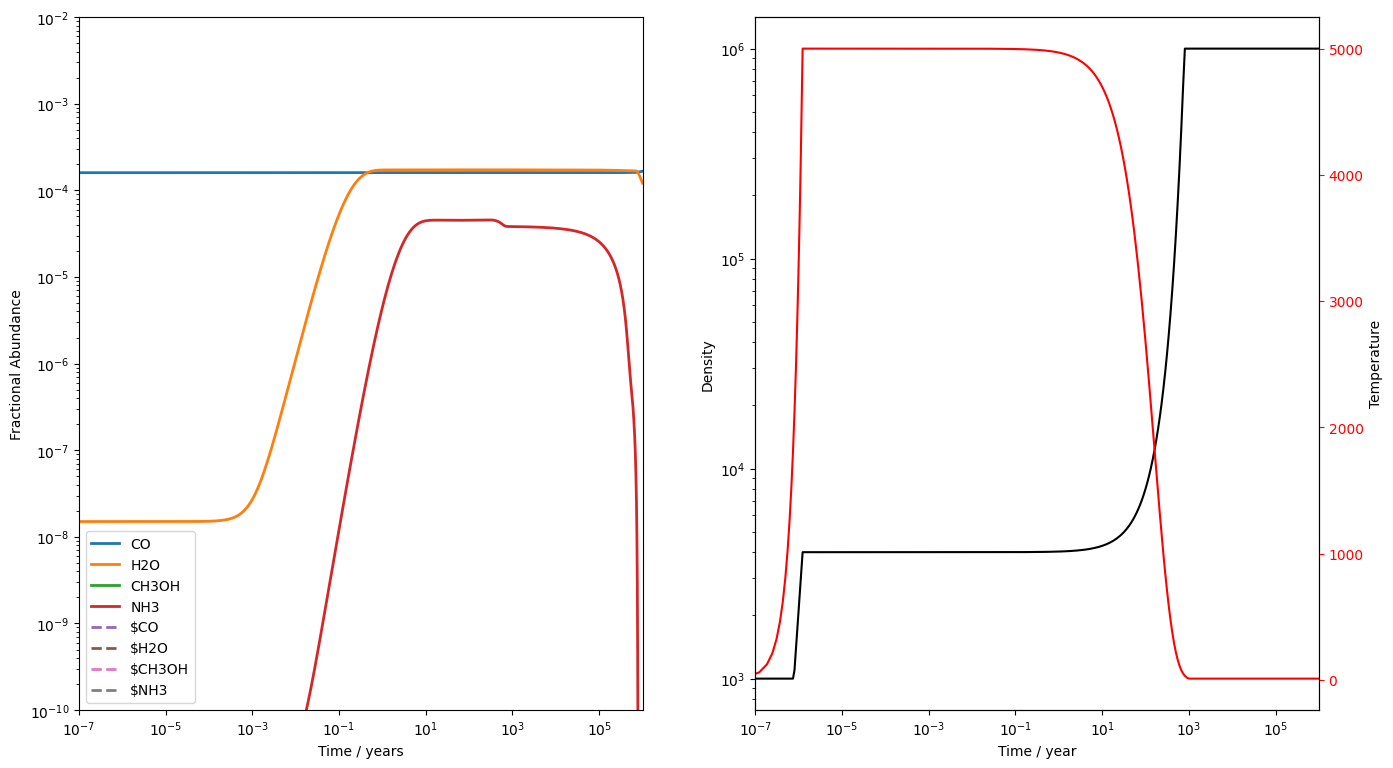

In [12]:
df_jshock = jshock.get_dataframes()
species = ["CO", "H2O", "CH3OH", "NH3", "$CO", "$H2O", "$CH3OH", "$NH3"]

fig, [ax, ax2] = plt.subplots(1, 2, figsize=(16, 9))
ax = jshock.plot_species(ax, species)
settings = ax.set(
    yscale="log",
    xlim=(1e-7, 1e6),
    ylim=(1e-10, 1e-2),
    xlabel="Time / years",
    ylabel="Fractional Abundance",
    xscale="log",
)

ax2.plot(df_jshock["Time"], df_jshock["Density"], color="black")
ax2.set(xscale="log", yscale="log")
ax3 = ax2.twinx()
ax3.plot(df_jshock["Time"], df_jshock["gasTemp"], color="red")
ax2.set(xlabel="Time / year", ylabel="Density")
ax3.set(ylabel="Temperature", facecolor="red", xlim=(1e-7, 1e6))
ax3.tick_params(axis="y", colors="red")

That's everything! We've run various science models using reasonable starting abundances that we produced by running a simple UCLCHEM model beforehand. One benefit of this method is that the abundances are consistent with the network. If we start with arbitrary, perhaps observationally motivated, abundances, it would be possible to initiate the model in a state our network could never produce.

However, one should be aware of the limitations of this method. A freefall collapse from low density to high is not really how a molecular cloud forms and so the abundances are only approximately similar to values they'd truly have in a real cloud. Testing whether your results are sensitive to things like the time you run the preliminary for or the exact density is a good way to make sure these approximations are not problematic.

Bear in mind that you can use `abundSaveFile` and `abundLoadFile` in the same model run. This lets you chain model runs together. For example, you could run a c-shock from a cloud model as we did here and then a j-shock with the c-shock's abundances as the initial abundances.